# Customer Churn

# Table of Contents

- [Problem Statement](#Problem-Statement)
- [Imports](#Imports)
- [Data Loading](#Data-Loading)
- [Data Merging](#Data-Merging)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-\(EDA\))
  - [Data Overview](#Data-Overview)
  - [Null/NaN Values](#Null/NaN-Values)
  - [Data Visualization](#Data-Visualization)
- [Data Preprocessing](#Data-Preprocessing)
  - [Categorical to Numerical Conversion](#Categorical-to-Numerical-Conversion)
  - [Visualization of Converted Features](#Visualization-of-Converted-Features)
    - [Cluster Map](#Cluster-Map)
    - [t-SNE Visualization](#t-SNE-Visualization)
- [Preliminary Baseline Model](#Preliminary-Baseline-Model)
  - [Modeling](#Modeling)
- [Feature Engineering and Selection](#Feature-Engineering-and-Selection)
  - [Feature Importance Analysis](#Feature-Importance-Analysis)
  - [Feature Selection](#Feature-Selection)
  - [Dimensionality Reduction](#Dimensionality-Reduction)
- [Handling Class Imbalance](#Handling-Class-Imbalance)
- [Model Comparisons](#Model-Comparisons)
- [Model Tuning](#Model-Tuning)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)


# Problem Statement

Customer churn is a significant concern for any business, especially in the telecommunications industry. Churn rate can significantly impact a company's revenue and market share. In this project, we are working with a dataset from a fictional telecommunications company - Telco. The data represents the information about 7043 customers in California for Q3, including those who left, stayed, or signed up for the service.

The aim of this project is to understand and predict customer churn, i.e., identify the factors that lead to customer churn and use this understanding to predict whether a customer is likely to churn in the future. These insights will help the company in developing effective customer retention strategies and enhance customer satisfaction.

To conduct this analysis, we are provided with multiple data points for each customer, including but not limited to demographics, location, services used, customer satisfaction score, churn score, and Customer Lifetime Value (CLTV).

The Telco data module comprises five main categories:

1. Demographics - Customer's unique ID, gender, age, marital status, dependents, etc.
2. Location - Details about the customer's primary residence.
3. Population - Estimated population of the customer's zip code area.
4. Services - Details about the services a customer is using and their billing information.
5. Status - This includes customer satisfaction score, churn label, churn value, churn score, CLTV, and reason for churn if applicable.

# Imports

In [58]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Data Loading

In [2]:
os.chdir('..')

In [3]:
cust_churn = pd.read_excel('data/Telco_customer_churn.xlsx')
demo = pd.read_excel('data/Telco_customer_churn_demographics.xlsx')
location = pd.read_excel('data/Telco_customer_churn_location.xlsx')
population = pd.read_excel('data/Telco_customer_churn_population.xlsx')
services = pd.read_excel('data/Telco_customer_churn_services.xlsx')
status = pd.read_excel('data/Telco_customer_churn_status.xlsx')
churn = pd.read_excel('data/Telco_customer_churn.xlsx')

# Data Merging

In [4]:
# Combine on Customer ID
churn_all = demo.merge(location, on='Customer ID')
churn_all = churn_all.merge(services, on='Customer ID')

# Include the 'Churn' column and any other relevant columns from the 'status' dataframe.
churn_all = churn_all.merge(status, on='Customer ID')

C:\Users\sergi\AppData\Local\Temp\ipykernel_10576\754748716.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Count_x'} in the result is deprecated and will raise a MergeError in a future version.
  churn_all = churn_all.merge(status, on='Customer ID')


# Data Cleaning

In [5]:
# Drop duplicated counts
churn_all.drop(['Count_x', 'Count_y'], axis=1, inplace=True)

# Drop all uniform columns
churn_all.drop(['Country', 'State', 'Quarter_x', 'Quarter_y'], axis=1, inplace=True)

# Drop columns that are redundant or unable to be converted to numerics
churn_all.drop(['Location ID', 'Service ID', 'Customer ID', 'Lat Long', 'City', 'Status ID'], axis=1, inplace=True)

# Exploratory Data Analysis (EDA)

## Data Overview

In [6]:
# Print the shape of the dataframe
print('Number of rows: ', churn_all.shape[0])
print('Number of columns: ', churn_all.shape[1])

Number of rows:  7043
Number of columns:  45


In [7]:
# Look at first 5 rows
churn_all.head()

,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Zip Code,Latitude,Longitude,...,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason
0,Male,78,No,Yes,No,No,0,90022,34.023810,-118.156582,...,0.00,59.65,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data
1,Female,74,No,Yes,Yes,Yes,1,90063,34.044271,-118.185237,...,390.80,1024.10,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer
2,Male,71,No,Yes,No,Yes,3,90065,34.108833,-118.229715,...,203.94,1910.88,2,Churned,Yes,1,81,3179,Competitor,Competitor made better offer
3,Female,78,No,Yes,Yes,Yes,1,90303,33.936291,-118.332639,...,494.00,2995.07,2,Churned,Yes,1,88,5337,Dissatisfaction,Limited range of services
4,Female,80,No,Yes,Yes,Yes,1,90602,33.972119,-118.020188,...,234.21,3102.36,2,Churned,Yes,1,67,2793,Price,Extra data charges


In [8]:
# Summary of the dataframe
churn_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Age                                7043 non-null   int64  
 2   Under 30                           7043 non-null   object 
 3   Senior Citizen                     7043 non-null   object 
 4   Married                            7043 non-null   object 
 5   Dependents                         7043 non-null   object 
 6   Number of Dependents               7043 non-null   int64  
 7   Zip Code                           7043 non-null   int64  
 8   Latitude                           7043 non-null   float64
 9   Longitude                          7043 non-null   float64
 10  Referred a Friend                  7043 non-null   object 
 11  Number of Referrals                7043 non-null   int64

In [9]:
# Summary statistics for numerical columns
churn_all.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Churn Value,Churn Score,CLTV
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,93486.071134,36.197455,-119.756684,1.951867,32.386767,22.958954,20.515405,64.761692,2280.381264,1.962182,6.860713,749.099262,3034.379056,3.244924,0.265370,58.505040,4400.295755
std,16.750352,0.962802,1856.768045,2.468929,2.154425,3.001199,24.542061,15.448113,20.418940,30.090047,2266.220462,7.902614,25.104978,846.660055,2865.204542,1.201657,0.441561,21.170031,1183.057152
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,21.360000,1.000000,0.000000,5.000000,2003.000000
25%,32.000000,0.000000,92101.000000,33.990646,-121.788090,0.000000,9.000000,9.210000,3.000000,35.500000,400.150000,0.000000,0.000000,70.545000,605.610000,3.000000,0.000000,40.000000,3469.000000
50%,46.000000,0.000000,93518.000000,36.205465,-119.595293,0.000000,29.000000,22.890000,17.000000,70.350000,1394.550000,0.000000,0.000000,401.440000,2108.640000,3.000000,0.000000,61.000000,4527.000000
75%,60.000000,0.000000,95329.000000,38.161321,-117.969795,3.000000,55.000000,36.395000,27.000000,89.850000,3786.600000,0.000000,0.000000,1191.100000,4801.145000,4.000000,1.000000,75.500000,5380.500000
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000,5.000000,1.000000,96.000000,6500.000000


## Null/NaN Values

In [10]:
# Check for missing values
missing_values = churn_all.isnull().sum()
print('Missing values per column:\n', missing_values[missing_values > 0])

Missing values per column:
 Churn Category    5174
Churn Reason      5174
dtype: int64


Looking into Churn Category & Churn Reason.

***Assumption***: 5174 cases of no churn (custom has not left), therefore it is NaN.

In [11]:
# Subset the data where 'Churn Category' and 'Churn Reason' are null
missing_churn_info = churn_all[churn_all['Churn Category'].isnull() & churn_all['Churn Reason'].isnull()]

# Check the 'Churn Label' column of this subset
churn_labels_in_missing = missing_churn_info['Churn Label'].value_counts()

print(churn_labels_in_missing)

No    5174
Name: Churn Label, dtype: int64


***Assumption is confirmed.***

All instances of Null/NaN (being in Churn Category and Churn Reason columns) are where the Churn Label is 'No', therefore, the customer has not churned. 

To fix this, we will impute another category into Churn Category and Churn Reason, for instances of NaN's,

***Churn Category*** will be called ***'Retention'***

***Churn Reason*** will be called ***'Customer Retained'***

In [12]:
churn_all['Churn Category'].fillna('Retention', inplace=True)
churn_all['Churn Reason'].fillna('Customer Retained', inplace=True)

## Data Visualization

<Axes: xlabel='Churn Label', ylabel='Count'>

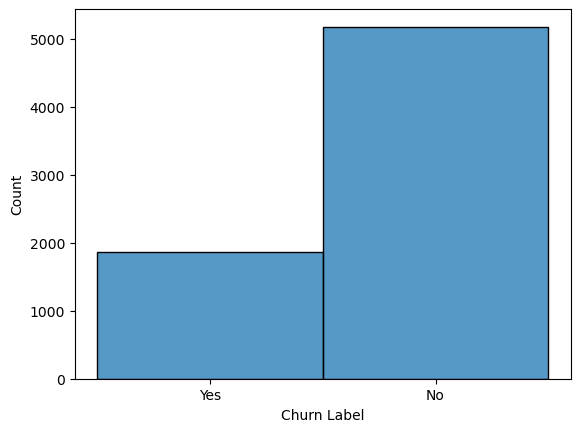

In [13]:
# Histogram of the target variable
sns.histplot(churn_all['Churn Label'])

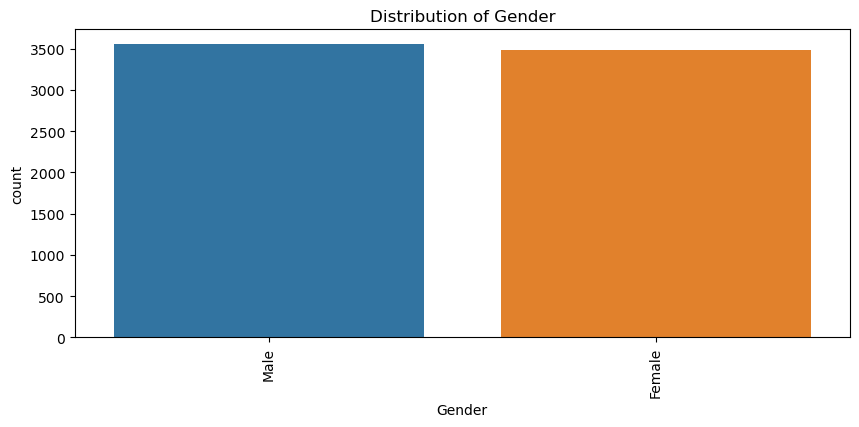

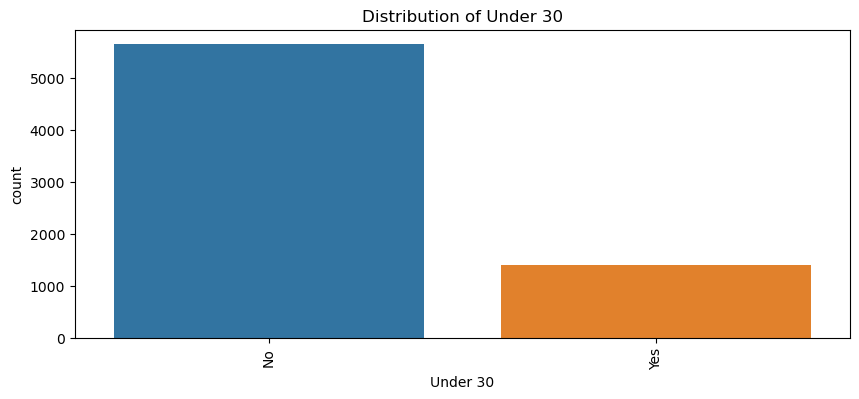

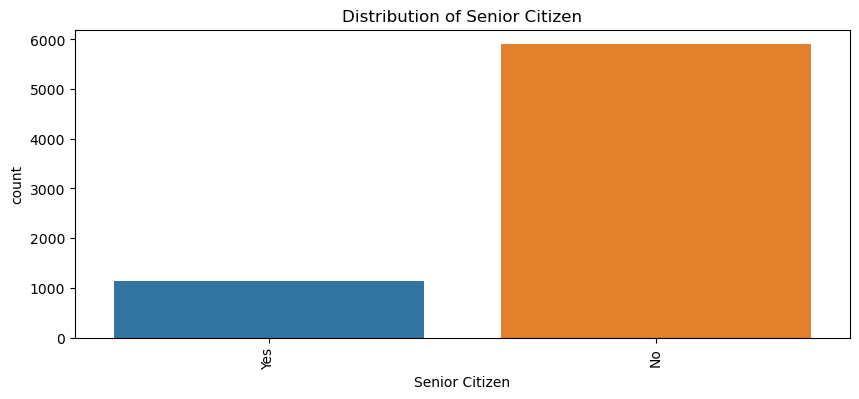

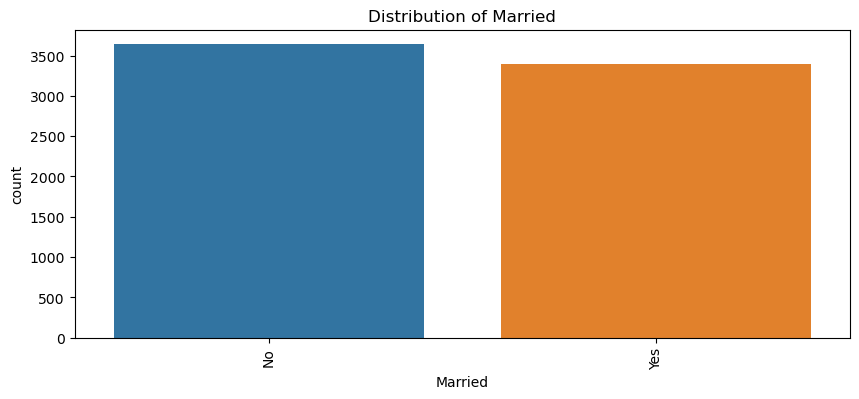

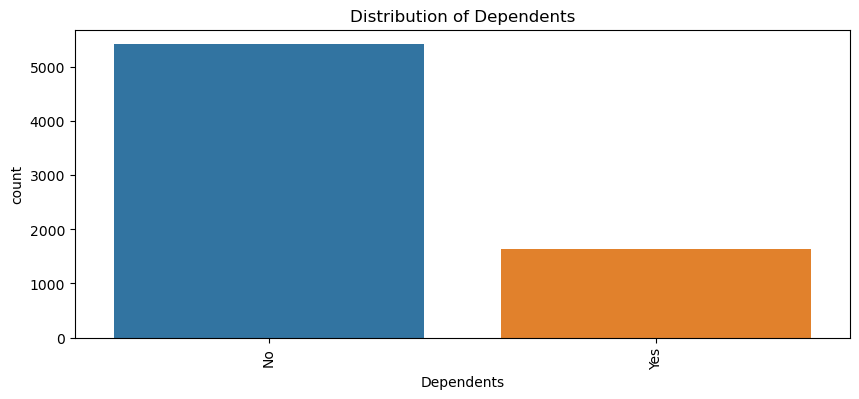

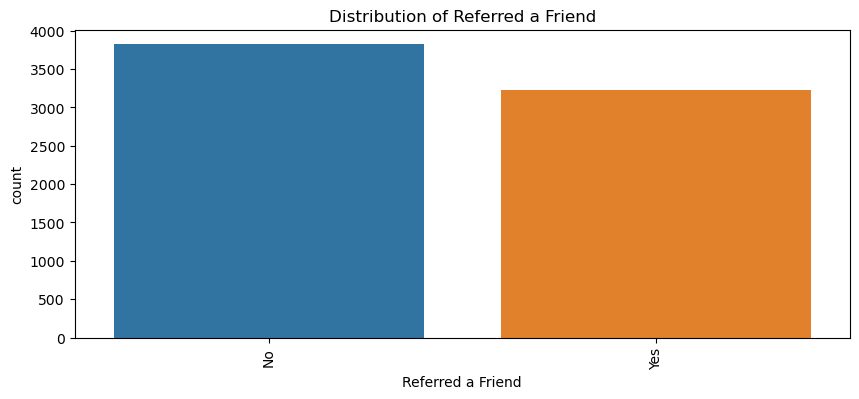

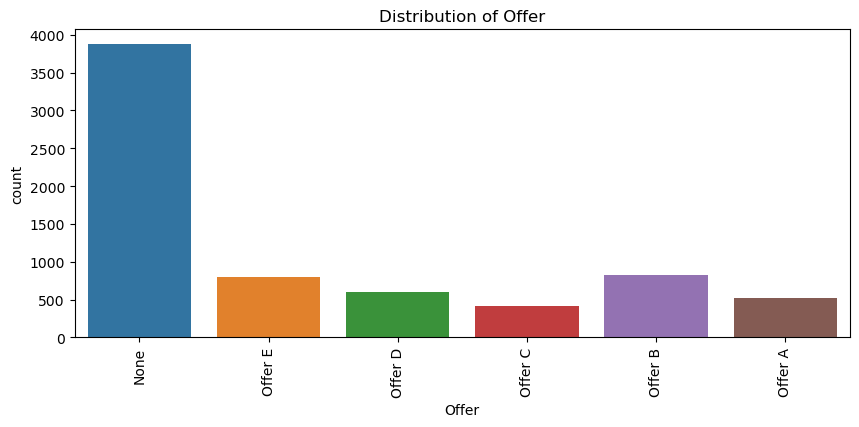

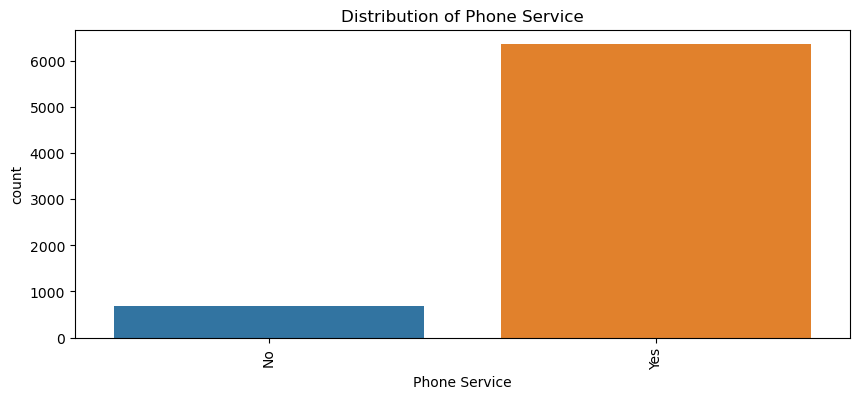

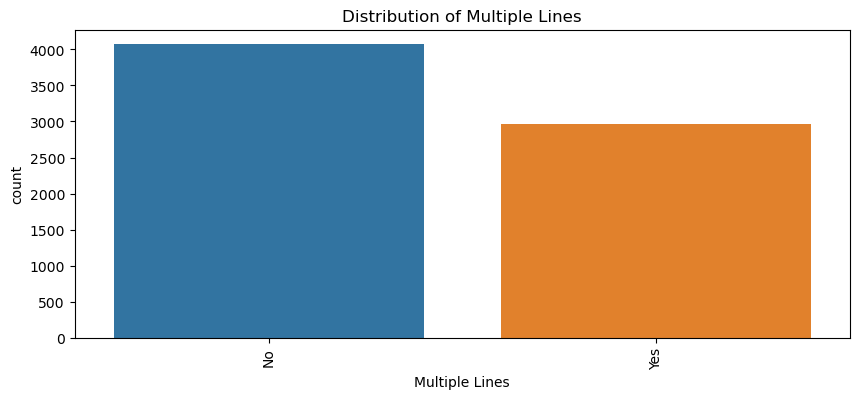

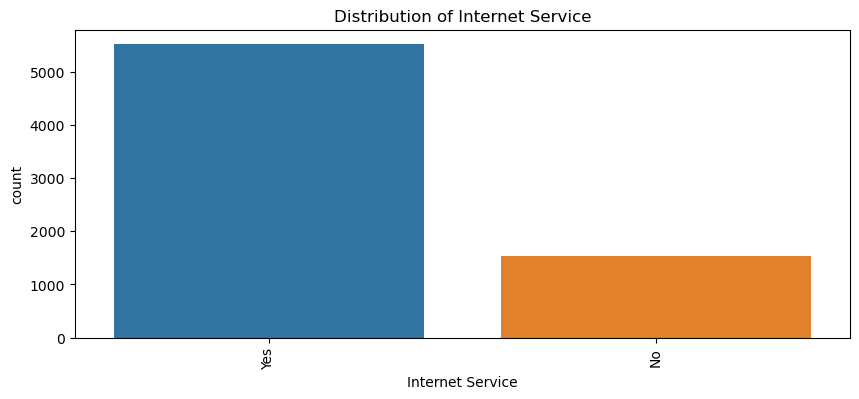

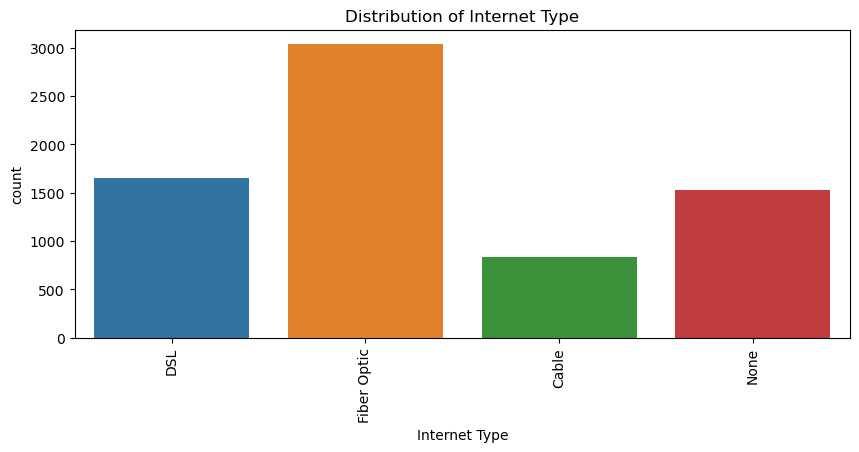

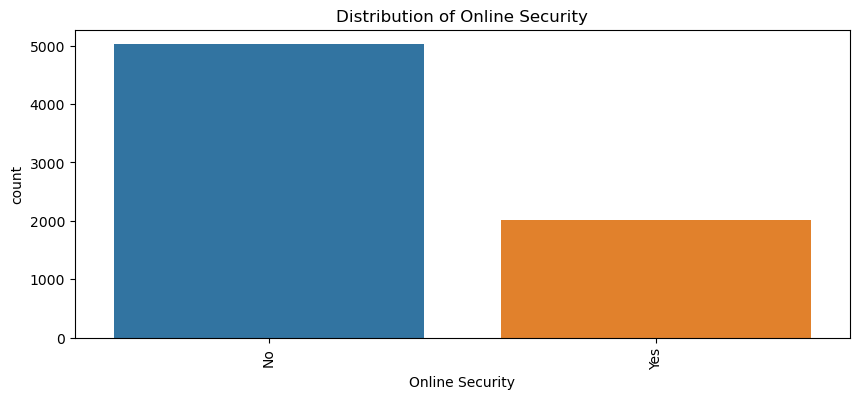

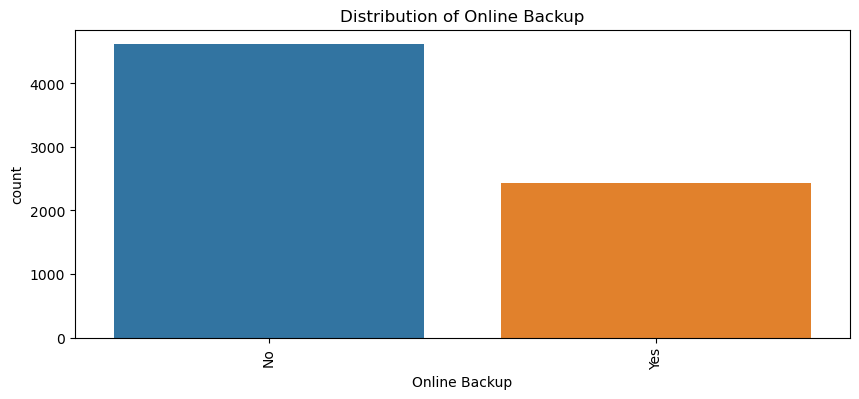

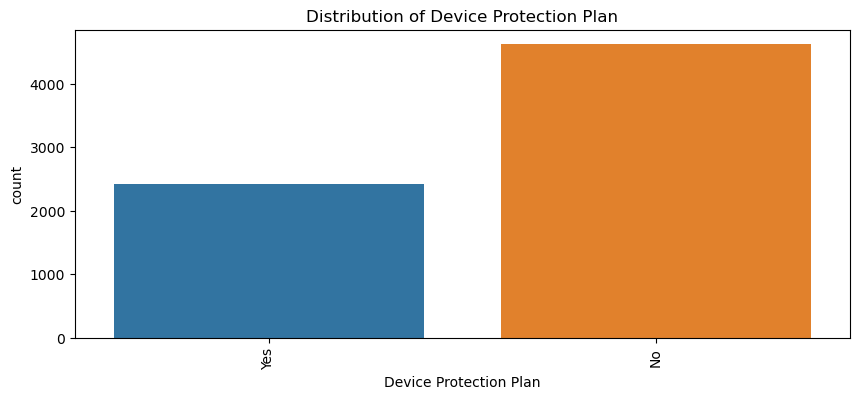

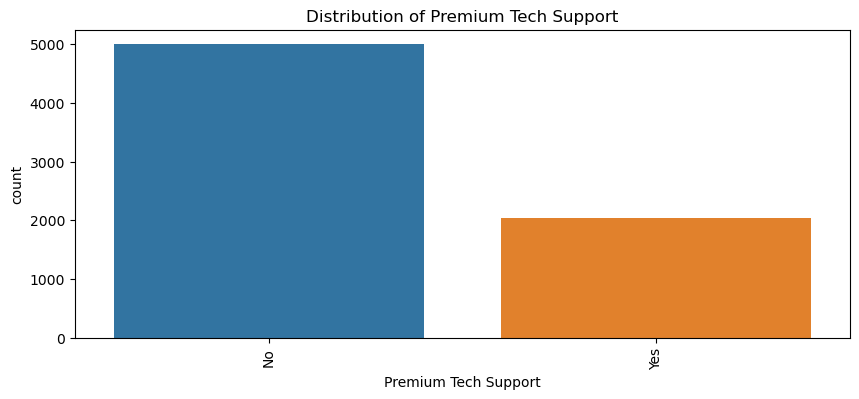

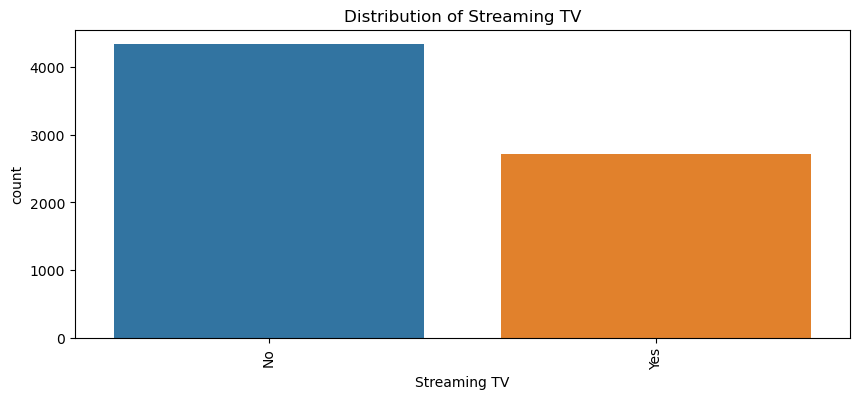

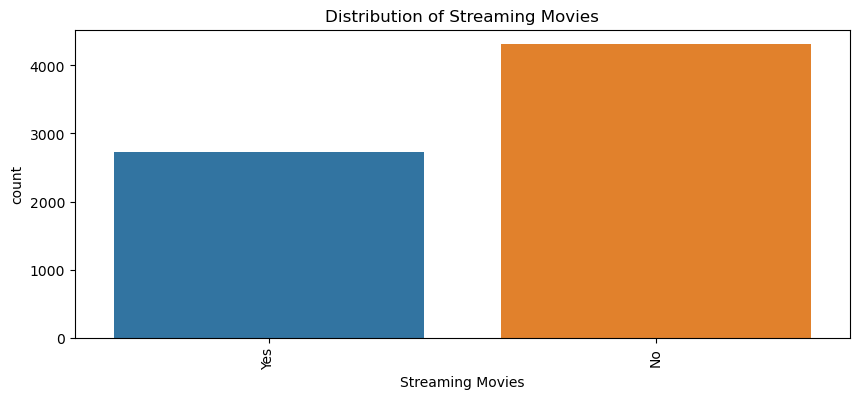

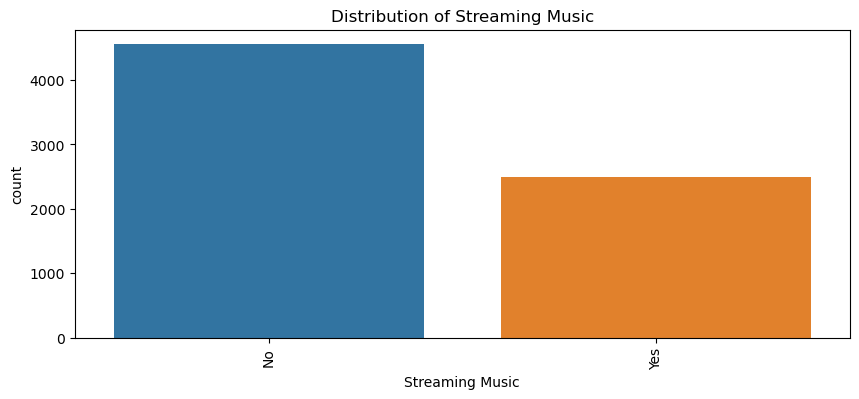

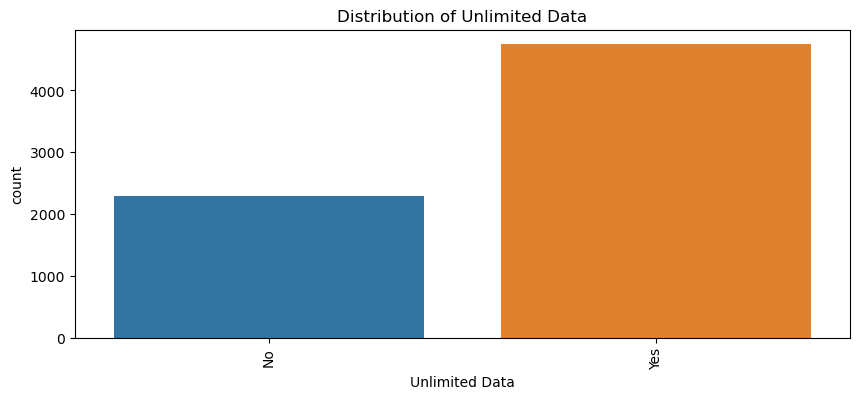

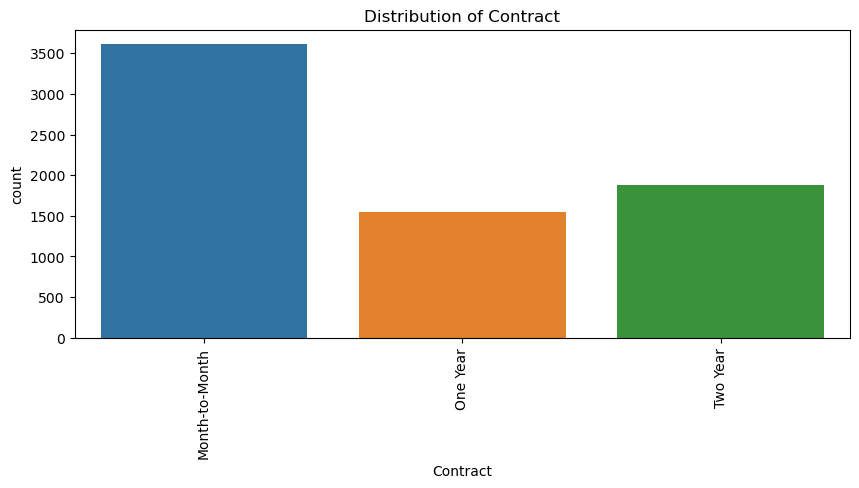

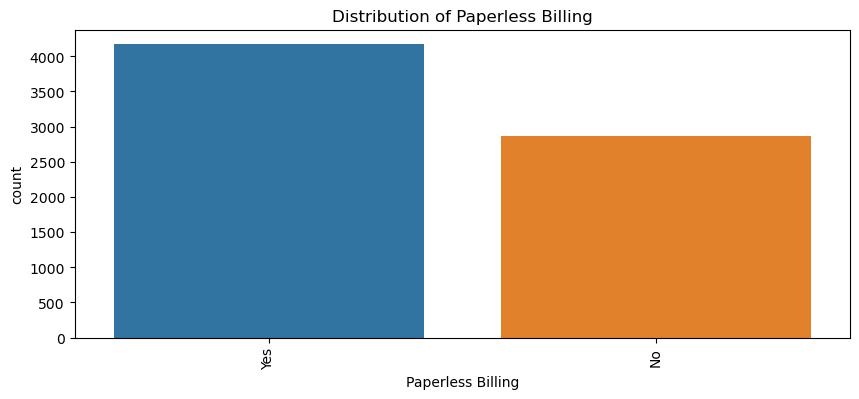

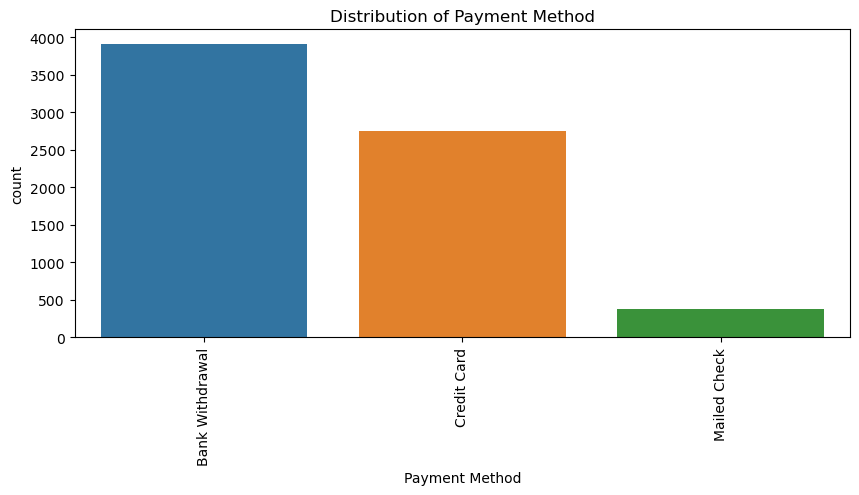

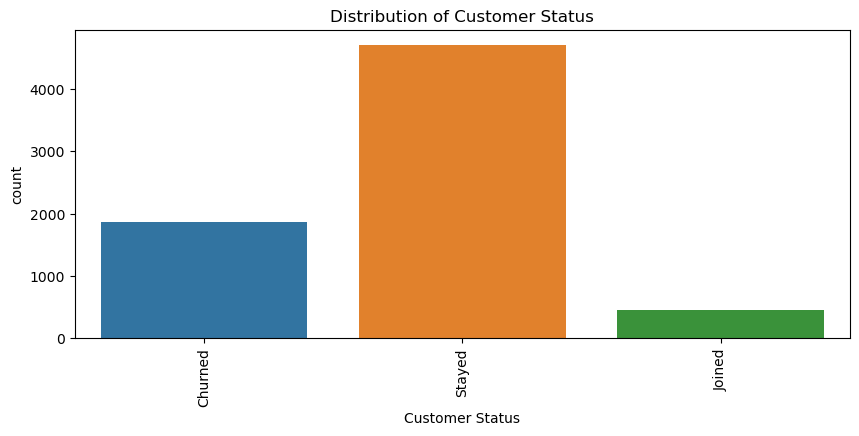

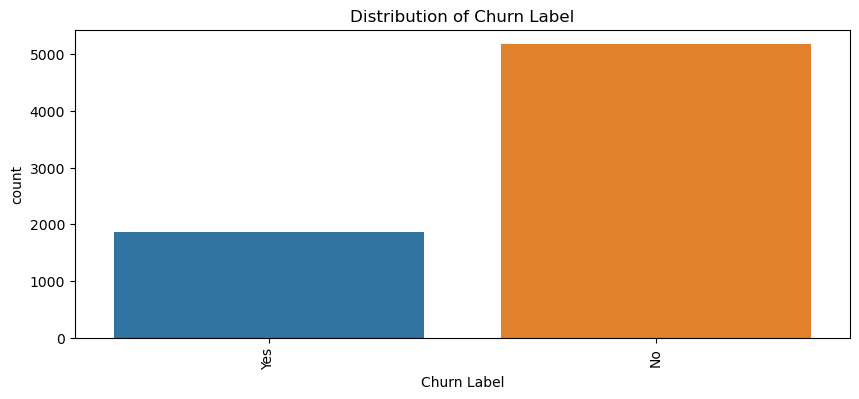

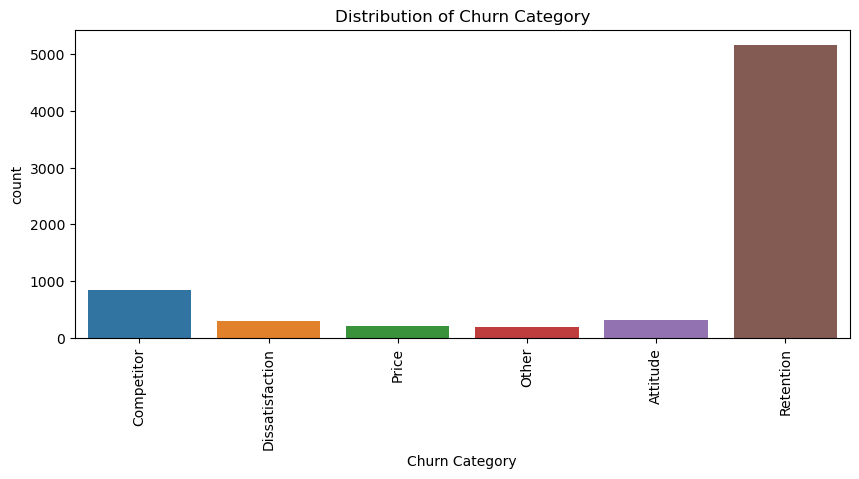

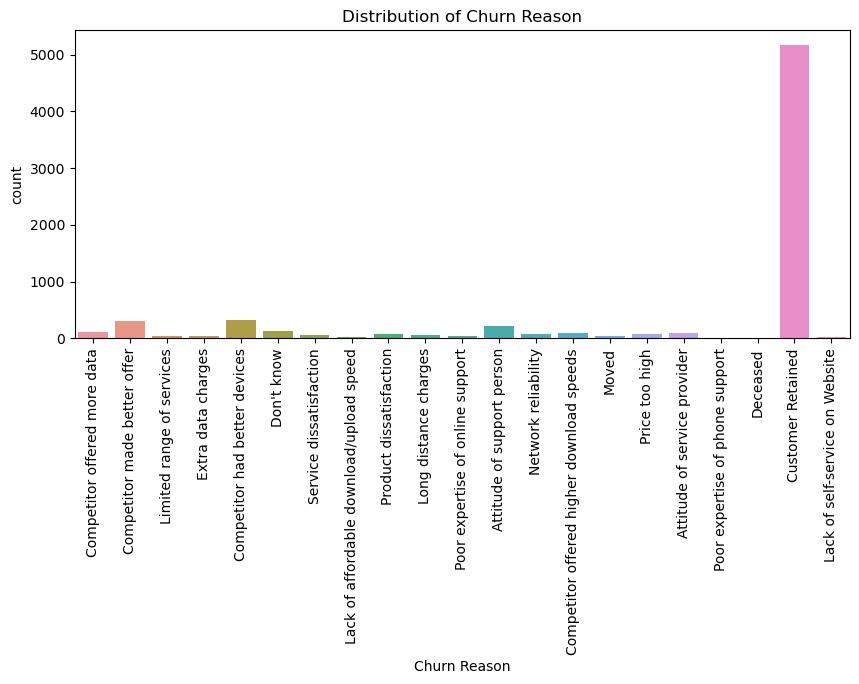

In [14]:
# Bar plots for categorical variables
categorical_cols = churn_all.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(x=col, data=churn_all)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.show()

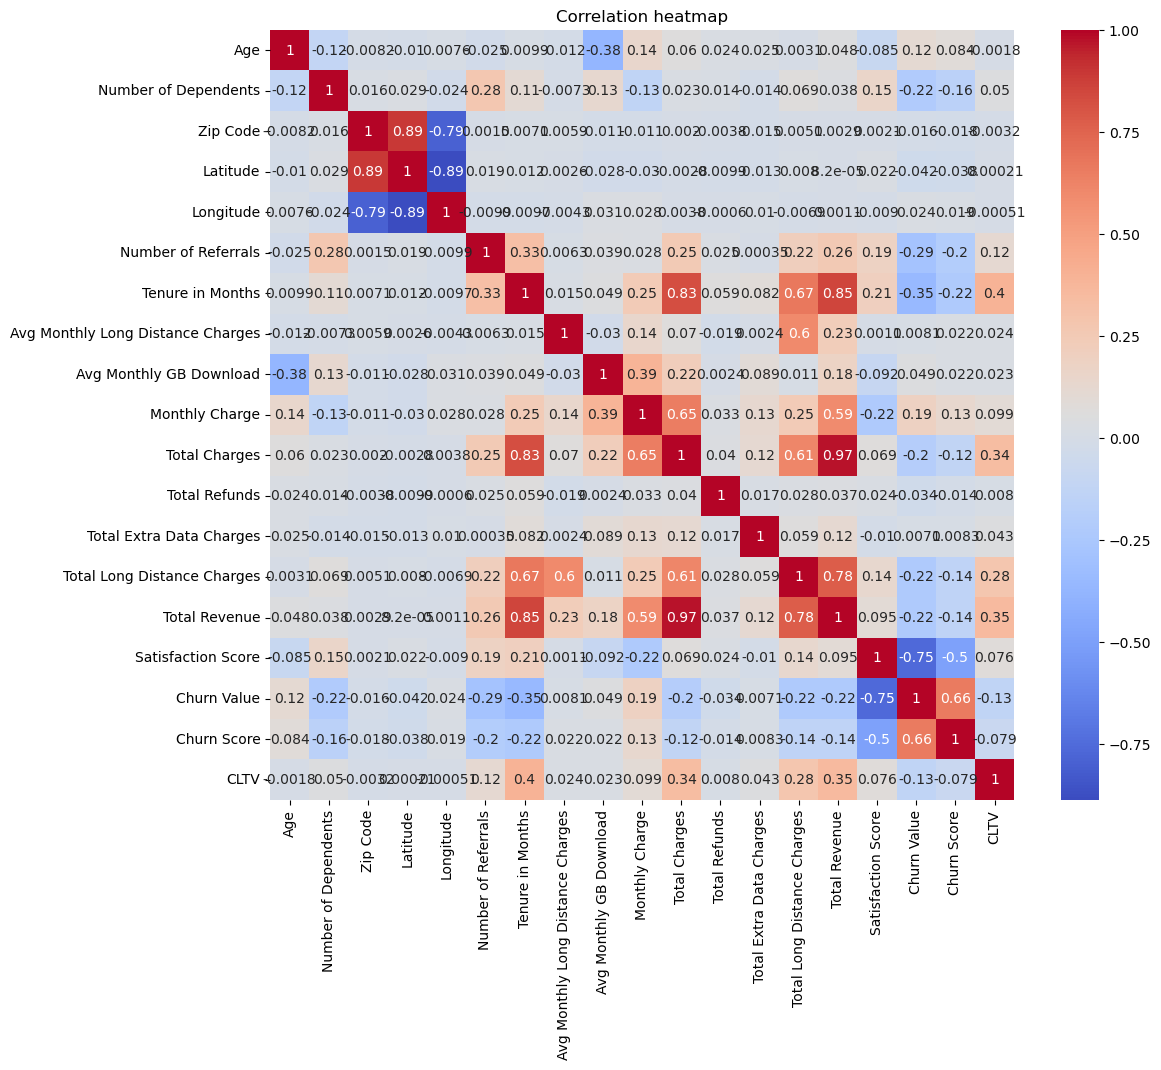

In [15]:
# Correlation heatmap for numerical variables
numerical_cols = churn_all.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12,10))
sns.heatmap(churn_all[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

# Data Preprocessing

## Categorical to Numerical Conversion

In [16]:
# Convert No/Yes to 0/1
churn_all['Under 30'] = churn_all['Under 30'].map(dict(Yes=1, No=0))
churn_all['Senior Citizen'] = churn_all['Senior Citizen'].map(dict(Yes=1, No=0))
churn_all['Married'] = churn_all['Married'].map(dict(Yes=1, No=0))
churn_all['Dependents'] = churn_all['Dependents'].map(dict(Yes=1, No=0))
churn_all['Referred a Friend'] = churn_all['Referred a Friend'].map(dict(Yes=1, No=0))
churn_all['Phone Service'] = churn_all['Phone Service'].map(dict(Yes=1, No=0))
churn_all['Multiple Lines'] = churn_all['Multiple Lines'].map(dict(Yes=1, No=0))
churn_all['Internet Service'] = churn_all['Internet Service'].map(dict(Yes=1, No=0))
churn_all['Online Security'] = churn_all['Online Security'].map(dict(Yes=1, No=0))
churn_all['Online Backup'] = churn_all['Online Backup'].map(dict(Yes=1, No=0))
churn_all['Device Protection Plan'] = churn_all['Device Protection Plan'].map(dict(Yes=1, No=0))
churn_all['Premium Tech Support'] = churn_all['Premium Tech Support'].map(dict(Yes=1, No=0))
churn_all['Streaming TV'] = churn_all['Streaming TV'].map(dict(Yes=1, No=0))
churn_all['Streaming Movies'] = churn_all['Streaming Movies'].map(dict(Yes=1, No=0))
churn_all['Streaming Music'] = churn_all['Streaming Music'].map(dict(Yes=1, No=0))
churn_all['Unlimited Data'] = churn_all['Unlimited Data'].map(dict(Yes=1, No=0))
churn_all['Paperless Billing'] = churn_all['Paperless Billing'].map(dict(Yes=1, No=0))
churn_all['Churn Label'] = churn_all['Churn Label'].map(dict(Yes=1, No=0))

# Convert Gender to a Binary
churn_all['Gender'] = churn_all['Gender'].map(dict(Female=1, Male=0))

# One Hot Encode categoricals (They are not numerically sound)
churn_all = pd.get_dummies(churn_all, columns=['Offer', 'Internet Type', 'Contract', 'Payment Method', 'Customer Status', 'Churn Category', 'Churn Reason'])

Checking if all objects are converted to numericals

In [17]:
if churn_all.select_dtypes(include=['object']).shape[1] == 0:
    print("All object columns successfully converted to numerics!")
else:
    print("Some object columns are still not converted.")

All object columns successfully converted to numerics!


## Visualization of Converted Features

### Cluster Map

Cluster Map to visualize the objects now converted to numerics and their correlation with other columns

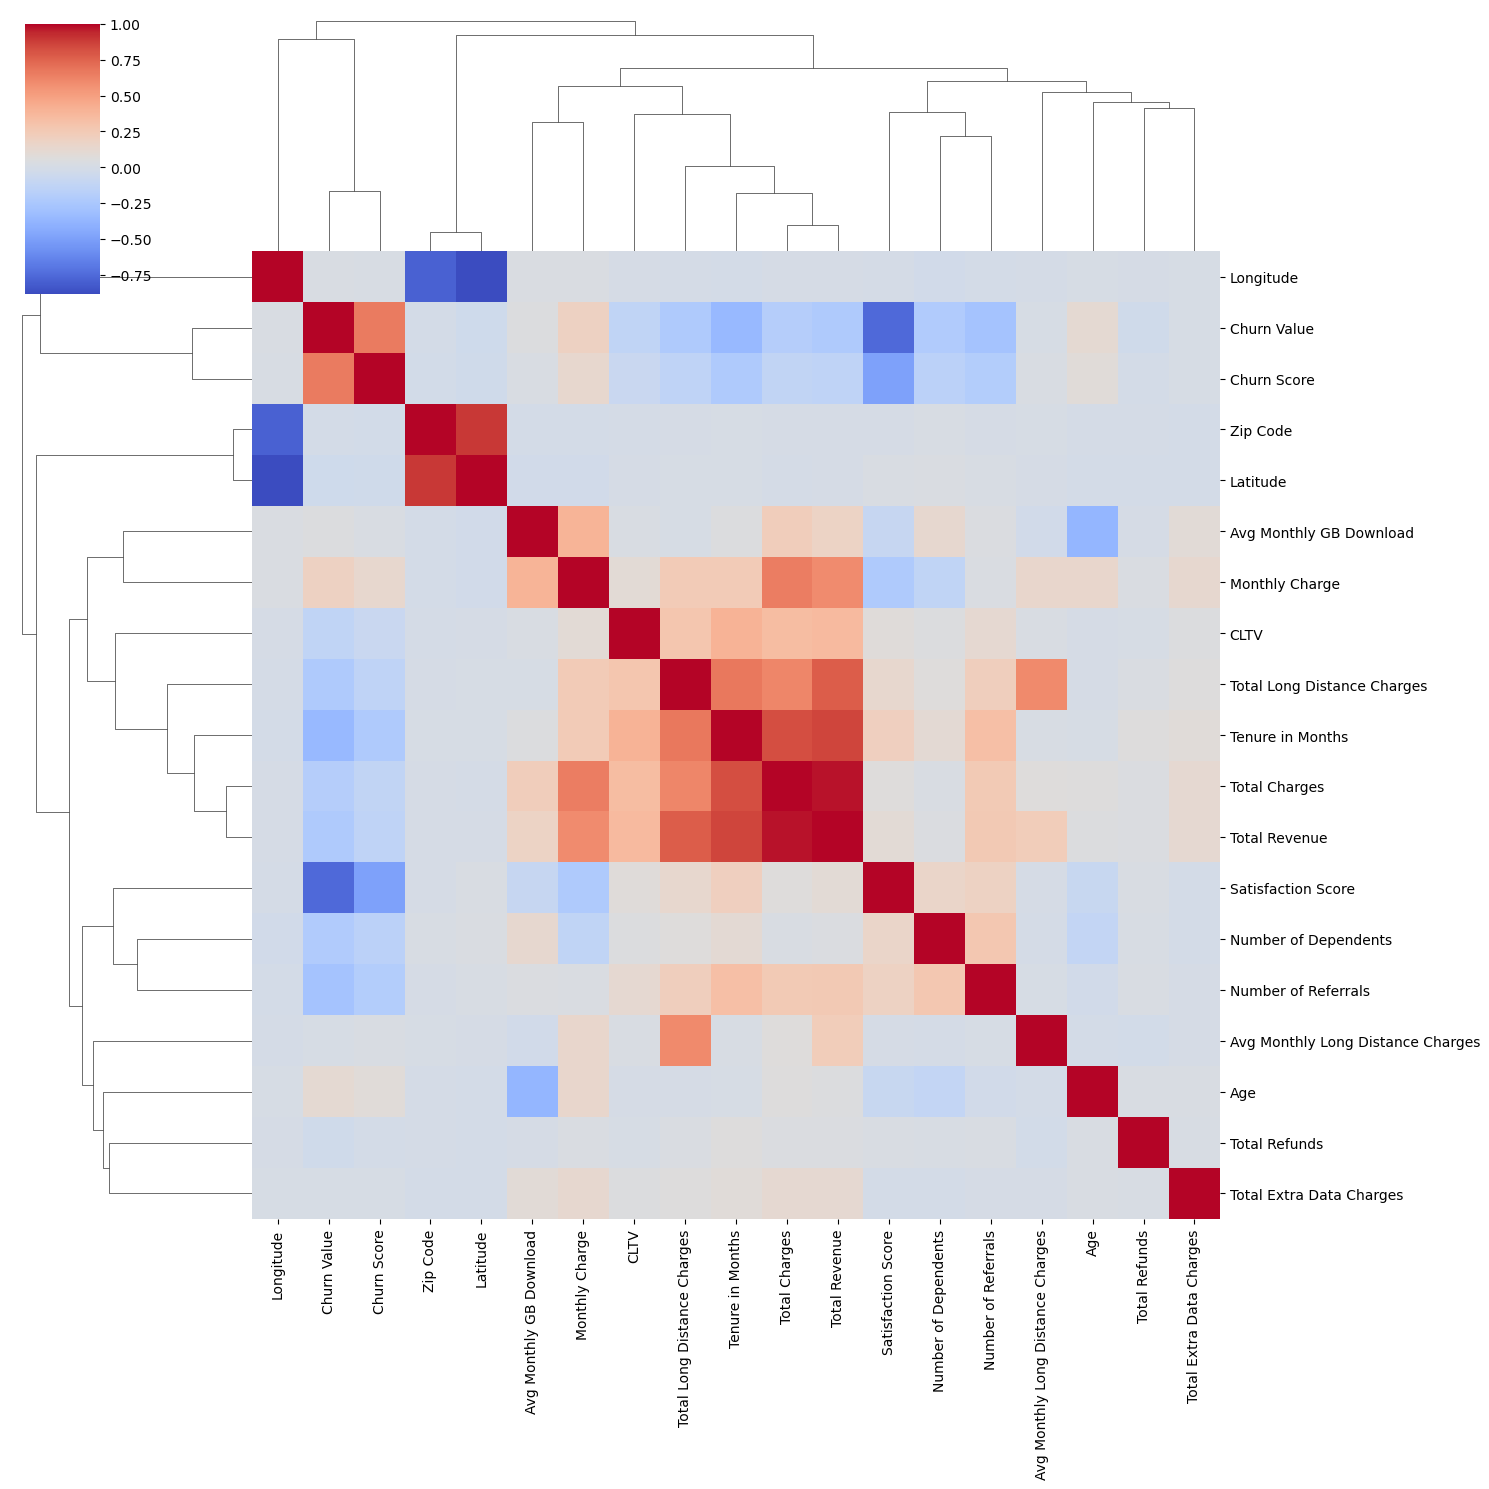

In [18]:
sns.clustermap(churn_all[numerical_cols].corr(), annot=False, cmap='coolwarm', figsize=(15,15))

The cluster map visually represents correlation values amongst the various columns in the dataset. On observing this representation, we notice a few interesting aspects:

1. **Churn Related Features:** The features 'Churn Score', 'Churn Label', and 'Churn Value' form a distinct cluster. This indicates a high level of correlation amongst these variables, which is expected, as they are all directly related to whether a customer has churned or not.

2. **Lack of Individual Strong Indicators:** It's noteworthy that none of the other features form a close cluster with the churn-related features. This observation suggests that no single feature is a strong determinant of churn. It likely reflects the multifaceted nature of customer behavior, where a combination of various features might influence a customer's decision to churn or not.

3. **Hierarchical Clustering (Dendrogram):** The tree-like structure seen at the top and left of the cluster map is known as a dendrogram. This structure shows a hierarchical clustering of features based on their correlation. The features with higher correlation are grouped together.

This exploration provides valuable insights about the correlation and potential relationships amongst different features. However, the predictive importance of these features will be better understood when we fit and evaluate a machine learning model. This process will provide a more quantitative measure of feature importance in the context of predicting customer churn.


### t-SNE Visualization

In [71]:
X = churn_all.drop(['Churn Value'], axis=1) 
y = churn_all['Churn Value']

In [72]:
# Fit and transform X to visualizable lower dimensions
transformed = TSNE(n_components=2, random_state=0, perplexity=200, learning_rate=700).fit_transform(X)

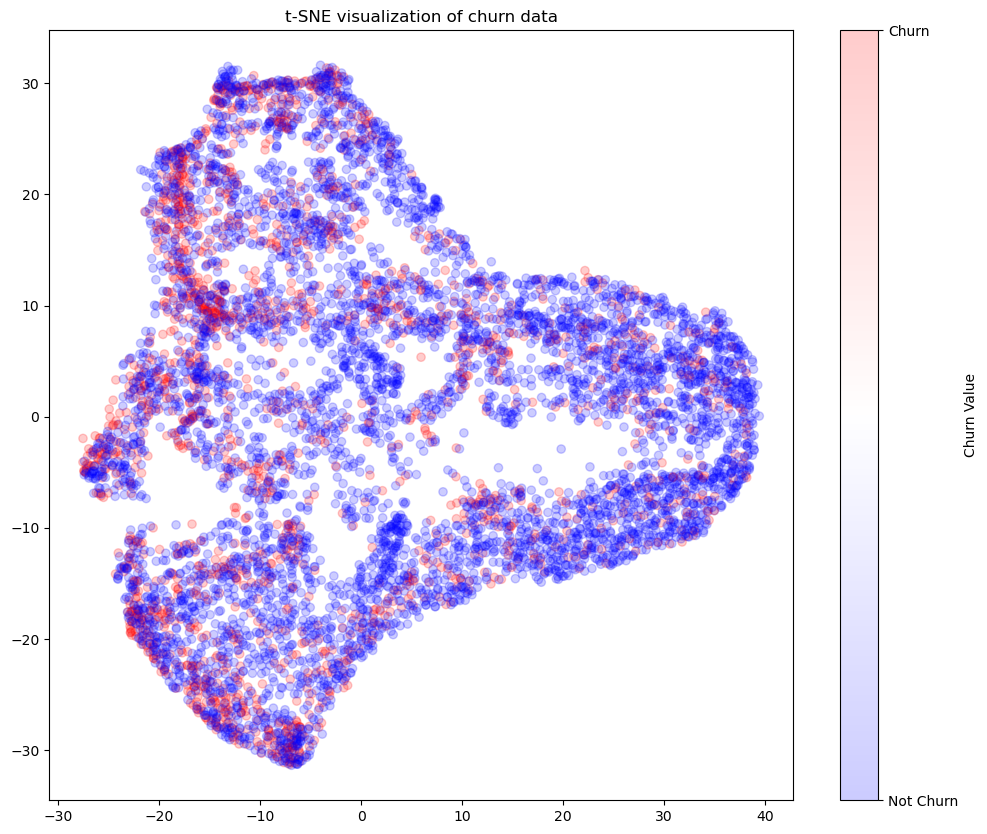

In [73]:
# Plot
plt.figure(figsize=(12,10))

scatter = plt.scatter(transformed[:,0], transformed[:,1], c=y, alpha=0.2, cmap='bwr') # 'bwr' is blue-white-red palette
plt.title('t-SNE visualization of churn data')

# Create a colorbar
cbar = plt.colorbar(scatter, ticks=[0,1])
cbar.set_label('Churn Value')
cbar.set_ticklabels(['Not Churn', 'Churn']) # 0 is "Not Churn", 1 is "Churn"

plt.show()

The t-SNE visualization above illustrates a high-dimensional churn dataset projected into a two-dimensional space. This graphical representation allows us to examine the relationship and potential clusters among customers based on their churn status. Our dataset contains 7043 records, out of which 5174 customers have not churned ('Not Churn').

While there are discernible patterns in the data, it is important to note that the visualization does not exhibit a clear and distinct separation between the 'Churn' and 'Not Churn' classes. 'Not Churn' instances are widely scattered throughout the plot, signifying a diverse set of attributes among customers who did not churn.

In comparison, the 'Churn' points seem to display a slightly more coherent structure, as most of these points tend to be concentrated below the 0 point on the x-axis. This could potentially suggest that the attributes of churned customers share some similarities, thus exhibiting a denser clustering in that specific region.

Despite this, it is evident that the 'Churn' instances are not exclusively confined to that area and are still dispersed across the plot. This highlights the complex and multi-faceted nature of customer churn, hinting at the presence of multiple factors that could lead to a customer's decision to leave the service.

This data visualization underscores the potential feasibility of predicting customer churn using machine learning algorithms. Nonetheless, the overlap between 'Churn' and 'Not Churn' instances suggests that achieving high predictive accuracy may be challenging due to the inherent intricacies in customer behavior. Hence, it is essential to further explore the data and refine our prediction model for improved outcomes.

# Preliminary Baseline Model

In [ ]:
**************************************************************

Something is going wrong in this next section
**************************************************************

In [74]:
# Divide data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [75]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the model 
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [76]:
# Predict the labels of the test set
y_pred = logreg.predict(X_test)

In [77]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1036
           1       1.00      1.00      1.00       373

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



In [78]:
# Print confusion matrix
print(confusion_matrix(y_test, y_pred))

[[1036    0]
 [   0  373]]


In [79]:
# Print accuracy score
print('Accuracy score: ', accuracy_score(y_test, y_pred))

Accuracy score:  1.0


In [80]:
# Iterate over each column in the dataframe
for column in churn_all.columns:
    # Check if this column is identical to the target variable
    if churn_all[column].equals(churn_all['Churn Value']):
        print(f'Column {column} is identical to the target variable.')

Column Churn Value is identical to the target variable.


In [70]:
# Drop the 'Churn Label' column
churn_all = churn_all.drop('Churn Label', axis=1)

## Modeling

# Feature Engineering and Selection

## Feature Importance Analysis

## Feature Selection

## Dimensionality Reduction

# Handling Class Imbalance

# Model Comparisons

# Model Tuning

# Model Evaluation

# Conclusion